Libraries

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.0 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import shutil
import random
from torchvision import datasets, transforms
#from tqdm import tqdm, trange
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import get_linear_schedule_with_warmup

**download dataset**

In [ ]:
train_tfms = transforms.Compose([transforms.ToTensor(),
                         transforms.RandomRotation(15)])

In [ ]:
dataset=datasets.MNIST(root="pics",
                              train=True,
                              download=True,
                              transform=train_tfms)

test_dataset=datasets.MNIST(root="pics",
                              train=False,
                              download=True,
                              transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 84962482.77it/s]


Extracting pics/MNIST/raw/train-images-idx3-ubyte.gz to pics/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40084610.80it/s]


Extracting pics/MNIST/raw/train-labels-idx1-ubyte.gz to pics/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21100538.50it/s]


Extracting pics/MNIST/raw/t10k-images-idx3-ubyte.gz to pics/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7392521.83it/s]


Extracting pics/MNIST/raw/t10k-labels-idx1-ubyte.gz to pics/MNIST/raw



Dataset split

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

Transforms-with normalization

dataset playing

In [ ]:
len(test_dataset)

10000

In [ ]:
image,label=train_ds[0]
image.shape

torch.Size([1, 28, 28])

In [ ]:
train_ds[0][0].shape

torch.Size([1, 28, 28])

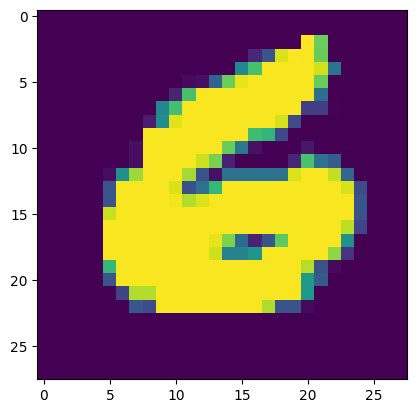

In [ ]:
plt.imshow(image.permute(1,2,0))

In [ ]:
def show_example(img, label):
    print('Label: ',label)
    plt.imshow(img.permute(1, 2, 0),cmap='gray_r')

Label:  1


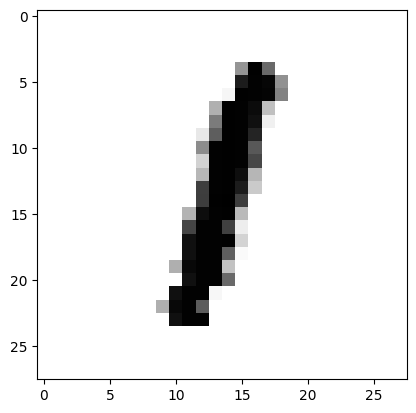

In [ ]:
show_example(*train_ds[1000])

Dataloader

In [ ]:
#arguments
train_batch_size_1=32
train_batch_size_2=64
train_batch_size_3=128
train_batch_size_4=256

val_batch_size=512
test_batch_size=512
input_size=28*28
classes=10

In [ ]:
train_loader=DataLoader(train_ds,train_batch_size_2,shuffle=True)
# train_loader_2=DataLoader(train_ds,train_batch_size_2,shuffle=True)
# train_loader_3=DataLoader(train_ds,train_batch_size_3,shuffle=True)
# train_loader_4=DataLoader(train_ds,train_batch_size_4,shuffle=True)

val_loader=DataLoader(val_ds,val_batch_size)
test_loader=DataLoader(test_dataset,val_batch_size)

Arguments

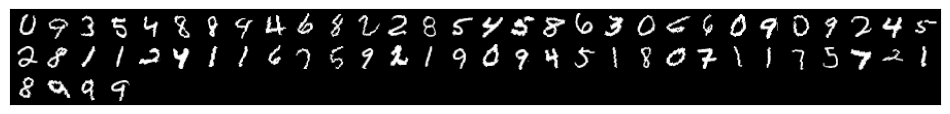

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=30).permute(1, 2, 0),cmap='gray_r')
        break

show_batch(train_loader)

USE GPU

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def device_type():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')


def to_device(data,device):#transfer to gpu
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking= True)


class deviceDataloader():#wrap dataloaders
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for batchy in self.dl:
      yield to_device(batchy,self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
device=device_type()
device

device(type='cuda')

In [ ]:
train_loader=deviceDataloader(train_loader,device)
# train_loader_2=deviceDataloader(train_loader_2,device)
# train_loader_3=deviceDataloader(train_loader_3,device)
# train_loader_4=deviceDataloader(train_loader_4,device)

val_loader=deviceDataloader(val_loader,device)
test_loader=deviceDataloader(test_loader,device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss,acc

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f} , train_acc: {:.4f} , val_loss: {:.4f} , val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

In [ ]:
# def conv_block(in_channels, out_channels, pool=False):
#     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#               nn.BatchNorm2d(out_channels),
#               nn.ReLU(inplace=True)]
#     if pool: layers.append(nn.MaxPool2d(2))
#     return nn.Sequential(*layers)

class MODEL(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,out_channels=12, kernel_size=3, stride=1, padding=0)#12*26*26
        self.conv2 = nn.Conv2d(in_channels=12,out_channels=48, kernel_size=3, stride=1, padding=0)#48*24*24

        self.norm=nn.BatchNorm2d(48)
        self.act=nn.ReLU()

        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2) #48*12*12
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2) #48*6*6

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(48*6*6, 10))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.norm(x)
        x = self.act(x)
        x = self.pool1(x)
        x = self.pool2(x)
        x = self.act(x)
        x = self.classifier(x)
        return x

In [ ]:
model_1 = to_device(MODEL(), device)
model_1

MODEL(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1728, out_features=10, bias=True)
  )
)

Training Steps

In [ ]:
args = {}

args["num_train_epochs"] = 10
args["optimizer"] = torch.optim.Adam
args["learning_rate"] = 1e-3
args["weight_decay"] = 1e-3
args["grad_clip"] = False
args["adam_epsilon"] = 1e-8
args["output_dir"] = "./output/"
args["max_grad_norm"] = 1.0
args["save_steps"] = 1
args["dropout"] = 0.3
args["lambda"] = 0.001

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(args,model,train_loader,val_loader,lr):
  torch.cuda.empty_cache()
  history=[]

  optimizer=args["optimizer"](model.parameters(), lr=lr,weight_decay=args["weight_decay"])
  # sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,args["learning_rate"], epochs=args["num_train_epochs"],
  #                                           steps_per_epoch=len(train_loader))

  for epoch in range(args["num_train_epochs"]):
    model.train()
    train_losses=[]
    train_accs=[]
    lrs=[]
    for batch in train_loader:
          loss,acc=model.training_step(batch)
          train_losses.append(loss)
          train_accs.append(acc)
          loss.backward()

          # Gradient clipping
          if args["grad_clip"]:
            nn.utils.clip_grad_value_(model.parameters(), args["grad_clip"])

          optimizer.step()
          optimizer.zero_grad()

          # Record & update learning rate
          #lrs.append(get_lr(optimizer))
          #sched.step()

    #validation
    result=evaluate(model,val_loader)
    result['train_loss']=torch.stack(train_losses).mean().item()
    result['train_acc']=torch.stack(train_accs).mean().item()
   # result["lrs"]=lrs
    model.epoch_end(epoch,result)
    history.append(result)

  return history

TRAIN/TEST

In [ ]:
result0=evaluate(model_1,test_loader)
result0

{'val_loss': 2.3140838146209717, 'val_acc': 0.09733455628156662}

In [ ]:
%%time
try1=fit(args,model_1,train_loader,val_loader,1e-5)

Epoch [0], train_loss: 1.8132 , train_acc: 0.4146 , val_loss: 1.1831 , val_acc: 0.7387
Epoch [1], train_loss: 0.9978 , train_acc: 0.7283 , val_loss: 0.7472 , val_acc: 0.8255
Epoch [2], train_loss: 0.7073 , train_acc: 0.8124 , val_loss: 0.5728 , val_acc: 0.8587
Epoch [3], train_loss: 0.5615 , train_acc: 0.8467 , val_loss: 0.4762 , val_acc: 0.8778
Epoch [4], train_loss: 0.4751 , train_acc: 0.8706 , val_loss: 0.4150 , val_acc: 0.8935
Epoch [5], train_loss: 0.4182 , train_acc: 0.8855 , val_loss: 0.3649 , val_acc: 0.9063
Epoch [6], train_loss: 0.3761 , train_acc: 0.8953 , val_loss: 0.3336 , val_acc: 0.9127
Epoch [7], train_loss: 0.3397 , train_acc: 0.9050 , val_loss: 0.3055 , val_acc: 0.9175
Epoch [8], train_loss: 0.3149 , train_acc: 0.9127 , val_loss: 0.2787 , val_acc: 0.9259
Epoch [9], train_loss: 0.2968 , train_acc: 0.9167 , val_loss: 0.2656 , val_acc: 0.9307
CPU times: user 6min 33s, sys: 1.25 s, total: 6min 34s
Wall time: 6min 48s


In [ ]:
evaluate(model_1,test_loader)

{'val_loss': 0.1869191974401474, 'val_acc': 0.9530847668647766}

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    train_losses = [x.get('train_acc') for x in history]
    val_losses = [x['val_acc'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_losses(try1)

In [ ]:
plot_accuracies(try1)

In [ ]:
#save

torch.save(model_1.state_dict(),'model_1_bs_32.pth')

Model_2

In [ ]:
model_2 = to_device(MODEL(), device)
model_2

MODEL(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1728, out_features=10, bias=True)
  )
)

In [ ]:
%%time
try2=fit(args,model_2,train_loader,val_loader,1e-4)

Epoch [0], train_loss: 0.6288 , train_acc: 0.8173 , val_loss: 0.2896 , val_acc: 0.9229
Epoch [1], train_loss: 0.2605 , train_acc: 0.9258 , val_loss: 0.1997 , val_acc: 0.9470
Epoch [2], train_loss: 0.1949 , train_acc: 0.9435 , val_loss: 0.1564 , val_acc: 0.9564
Epoch [3], train_loss: 0.1633 , train_acc: 0.9526 , val_loss: 0.1351 , val_acc: 0.9638
Epoch [4], train_loss: 0.1457 , train_acc: 0.9573 , val_loss: 0.1176 , val_acc: 0.9670
Epoch [5], train_loss: 0.1321 , train_acc: 0.9606 , val_loss: 0.1128 , val_acc: 0.9686
Epoch [6], train_loss: 0.1217 , train_acc: 0.9647 , val_loss: 0.1022 , val_acc: 0.9712
Epoch [7], train_loss: 0.1155 , train_acc: 0.9653 , val_loss: 0.1048 , val_acc: 0.9700
Epoch [8], train_loss: 0.1121 , train_acc: 0.9666 , val_loss: 0.0956 , val_acc: 0.9719
Epoch [9], train_loss: 0.1064 , train_acc: 0.9674 , val_loss: 0.0919 , val_acc: 0.9744
CPU times: user 6min 30s, sys: 1.41 s, total: 6min 31s
Wall time: 6min 45s


In [ ]:
evaluate(model_2,test_loader)

{'val_loss': 0.05506257340312004, 'val_acc': 0.9836971163749695}

In [ ]:
plot_losses(try2)

In [ ]:
plot_accuracies(try2)

LR 3

In [ ]:
model_3 = to_device(MODEL(), device)
model_3

MODEL(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1728, out_features=10, bias=True)
  )
)

In [ ]:
%%time
try3=fit(args,model_3,train_loader,val_loader,1e-3)

Epoch [0], train_loss: 0.2632 , train_acc: 0.9185 , val_loss: 0.1194 , val_acc: 0.9650
Epoch [1], train_loss: 0.1271 , train_acc: 0.9601 , val_loss: 0.1259 , val_acc: 0.9588
Epoch [2], train_loss: 0.1068 , train_acc: 0.9664 , val_loss: 0.0976 , val_acc: 0.9712
Epoch [3], train_loss: 0.1003 , train_acc: 0.9690 , val_loss: 0.0839 , val_acc: 0.9751
Epoch [4], train_loss: 0.0885 , train_acc: 0.9730 , val_loss: 0.0754 , val_acc: 0.9759
Epoch [5], train_loss: 0.0875 , train_acc: 0.9722 , val_loss: 0.0797 , val_acc: 0.9761
Epoch [6], train_loss: 0.0863 , train_acc: 0.9731 , val_loss: 0.0750 , val_acc: 0.9785
Epoch [7], train_loss: 0.0820 , train_acc: 0.9746 , val_loss: 0.0687 , val_acc: 0.9785
Epoch [8], train_loss: 0.0816 , train_acc: 0.9735 , val_loss: 0.0722 , val_acc: 0.9777
Epoch [9], train_loss: 0.0802 , train_acc: 0.9753 , val_loss: 0.0718 , val_acc: 0.9788
CPU times: user 6min 19s, sys: 1.26 s, total: 6min 20s
Wall time: 6min 22s


In [ ]:
evaluate(model_3,test_loader)

{'val_loss': 0.0477227084338665, 'val_acc': 0.984702467918396}

Model 4

In [ ]:
model_4 = to_device(MODEL(), device)
model_4

MODEL(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1728, out_features=10, bias=True)
  )
)

In [ ]:
%%time
try4=fit(args,model_4,train_loader,val_loader,1e-2)

Epoch [0], train_loss: 0.3766 , train_acc: 0.9097 , val_loss: 0.1392 , val_acc: 0.9590
Epoch [1], train_loss: 0.1305 , train_acc: 0.9592 , val_loss: 0.1076 , val_acc: 0.9670
Epoch [2], train_loss: 0.1270 , train_acc: 0.9602 , val_loss: 0.1180 , val_acc: 0.9643
Epoch [3], train_loss: 0.1308 , train_acc: 0.9595 , val_loss: 0.1046 , val_acc: 0.9676
Epoch [4], train_loss: 0.1313 , train_acc: 0.9586 , val_loss: 0.1063 , val_acc: 0.9686
Epoch [5], train_loss: 0.1346 , train_acc: 0.9583 , val_loss: 0.1395 , val_acc: 0.9578
Epoch [6], train_loss: 0.1346 , train_acc: 0.9585 , val_loss: 0.1461 , val_acc: 0.9537
Epoch [7], train_loss: 0.1313 , train_acc: 0.9596 , val_loss: 0.1233 , val_acc: 0.9641
Epoch [8], train_loss: 0.1333 , train_acc: 0.9580 , val_loss: 0.1140 , val_acc: 0.9664
Epoch [9], train_loss: 0.1355 , train_acc: 0.9582 , val_loss: 0.1198 , val_acc: 0.9624
CPU times: user 6min 24s, sys: 1.28 s, total: 6min 25s
Wall time: 6min 38s


Compare

In [ ]:
def compare_train_losses():
    train_losses_1 = [x.get('train_loss') for x in try1]
    train_losses_2 = [x.get('train_loss') for x in try2]
    train_losses_3 = [x.get('train_loss') for x in try3]
    train_losses_4 = [x.get('train_loss') for x in try4]

    plt.plot(train_losses_1)
    plt.plot(train_losses_2)
    plt.plot(train_losses_3)
    plt.plot(train_losses_4)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['1e-5','1e-4','1e-3','1e-2'])
    plt.title('Training Loss vs. No. of epochs');

In [ ]:
def compare_val_losses():
    val_losses_1 = [x.get('val_loss') for x in try1]
    val_losses_2 = [x.get('val_loss') for x in try2]
    val_losses_3 = [x.get('val_loss') for x in try3]
    val_losses_4 = [x.get('val_loss') for x in try4]

    plt.plot(val_losses_1)
    plt.plot(val_losses_2)
    plt.plot(val_losses_3)
    plt.plot(val_losses_4)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['1e-5','1e-4','1e-3','1e-2'])
    plt.title('Val Loss vs. No. of epochs');

In [ ]:
def compare_train_accs():
    val_acc_1 = [x.get('train_acc') for x in try1]
    val_acc_2 = [x.get('train_acc') for x in try2]
    val_acc_3 = [x.get('train_acc') for x in try3]
    val_acc_4 = [x.get('train_acc') for x in try4]

    plt.plot(val_acc_1)
    plt.plot(val_acc_2)
    plt.plot(val_acc_3)
    plt.plot(val_acc_4)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['1e-5','1e-4','1e-3','1e-2'])
    plt.title('Train Accuracy vs. No. of epochs');

In [ ]:
def compare_val_accs():
    val_acc_1 = [x.get('val_acc') for x in try1]
    val_acc_2 = [x.get('val_acc') for x in try2]
    val_acc_3 = [x.get('val_acc') for x in try3]
    val_acc_4 = [x.get('val_acc') for x in try4]

    plt.plot(val_acc_1)
    plt.plot(val_acc_2)
    plt.plot(val_acc_3)
    plt.plot(val_acc_4)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['1e-5','1e-4','1e-3','1e-2'])
    plt.title('Val Accuracy vs. No. of epochs');

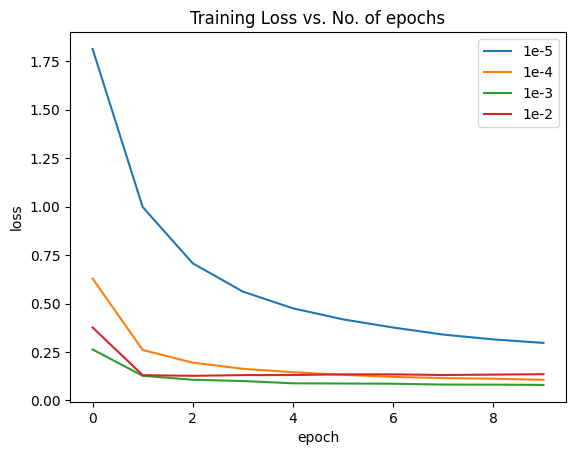

In [ ]:
compare_train_losses()

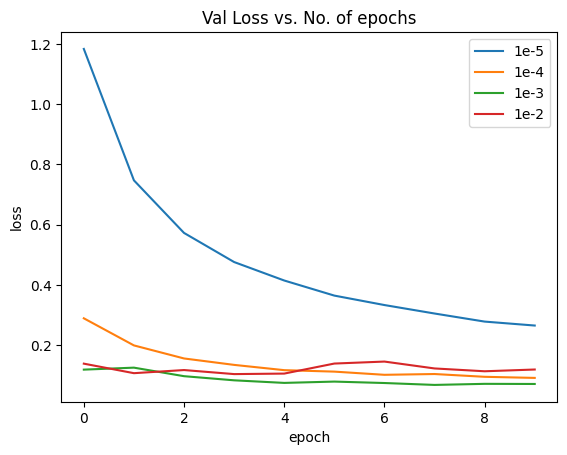

In [ ]:
compare_val_losses()

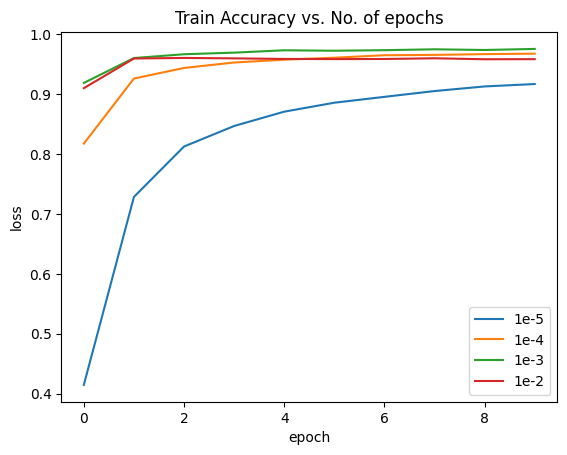

In [ ]:
compare_train_accs()

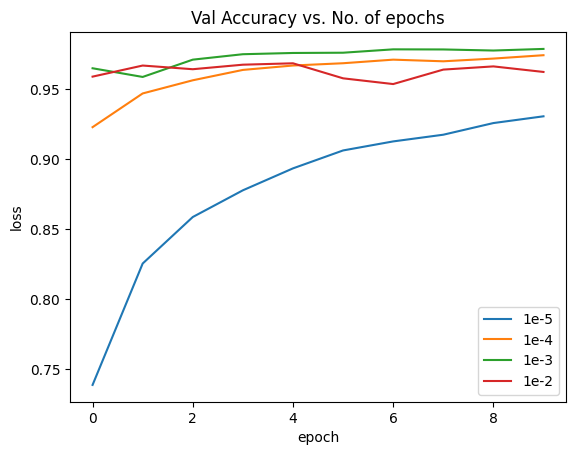

In [ ]:
compare_val_accs()

In [ ]:
#save

torch.save(model_1.state_dict(),'model_2_lr4.pth')

In [ ]:
#save

torch.save(model_1.state_dict(),'model_3_lr3.pth')

In [ ]:
#save

torch.save(model_1.state_dict(),'model_4_lr2.pth')

Conclusion-
* need to find precise learning rate for fastest training
* very high lr leads to fast training initially but then jumps around the saturation point     
*  very low lr takes very long to reach the same accuracy
* one solution is to use scheduler/ warm up which start the learning rate from low value, takes it to the max specified lr and again decreases as we come near end of the training epochs, which allows the benefit of both high and low learning rates at appropriate times








In [ ]:
# def conv_block(in_channels, out_channels, pool=False):
#     layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
#               nn.BatchNorm2d(out_channels),
#               nn.ReLU(inplace=True)]
#     if pool: layers.append(nn.MaxPool2d(2))
#     return nn.Sequential(*layers)

class MODEL1(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,out_channels=10, kernel_size=3, stride=1, padding=0)#10*26*26
        self.conv2 = nn.Conv2d(in_channels=10,out_channels=48, kernel_size=3, stride=1, padding=0)#48*24*24

        self.norm=nn.BatchNorm2d(48)
        self.act=nn.ReLU()

        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2) #48*12*12
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2) #48*6*6

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(48*6*6, 10))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.norm(x)
        x = self.act(x)
        x = self.pool1(x)
        x = self.pool2(x)
        x = self.act(x)
        x = self.classifier(x)
        return x

In [ ]:
class MODEL2(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,out_channels=10, kernel_size=3, stride=1, padding=0)#10*26*26
        self.conv2 = nn.Conv2d(in_channels=10,out_channels=48, kernel_size=3, stride=1, padding=0)#48*24*24

        self.norm=nn.BatchNorm2d(48)
        self.act=nn.Tanh()

        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2) #48*12*12
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2) #48*6*6

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(48*6*6, 10))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.norm(x)
        x = self.act(x)
        x = self.pool1(x)
        x = self.pool2(x)
        x = self.act(x)
        x = self.classifier(x)
        return x

In [ ]:
class MODEL3(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,out_channels=10, kernel_size=3, stride=1, padding=0)#10*26*26
        self.conv2 = nn.Conv2d(in_channels=10,out_channels=48, kernel_size=3, stride=1, padding=0)#48*24*24

        self.norm=nn.BatchNorm2d(48)
        self.act=nn.Sigmoid()

        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2) #48*12*12
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2) #48*6*6

        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(48*6*6, 10))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.norm(x)
        x = self.act(x)
        x = self.pool1(x)
        x = self.pool2(x)
        x = self.act(x)
        x = self.classifier(x)
        return x

In [ ]:
def fit2(args,model,train_loader,val_loader):
  torch.cuda.empty_cache()
  history=[]

  optimizer=args["optimizer"](model.parameters(), lr=args["learning_rate"],weight_decay=args["weight_decay"])
  sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,args["learning_rate"], epochs=args["num_train_epochs"],
                                             steps_per_epoch=len(train_loader))

  for epoch in range(args["num_train_epochs"]):
    model.train()
    train_losses=[]
    train_accs=[]
    lrs=[]
    for batch in train_loader:
          loss,acc=model.training_step(batch)
          train_losses.append(loss)
          train_accs.append(acc)
          loss.backward()

          # Gradient clipping
          if args["grad_clip"]:
            nn.utils.clip_grad_value_(model.parameters(), args["grad_clip"])

          optimizer.step()
          optimizer.zero_grad()

          # Record & update learning rate
          lrs.append(get_lr(optimizer))
          sched.step()

    #validation
    result=evaluate(model,val_loader)
    result['train_loss']=torch.stack(train_losses).mean().item()
    result['train_acc']=torch.stack(train_accs).mean().item()
    result["lrs"]=lrs
    model.epoch_end(epoch,result)
    history.append(result)

  return history

In [ ]:
model_a = to_device(MODEL1(), device)
model_a

MODEL1(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1728, out_features=10, bias=True)
  )
)

In [ ]:
%%time
trya=fit2(args,model_a,train_loader,val_loader)

Epoch [0], train_loss: 0.8671 , train_acc: 0.7394 , val_loss: 0.2766 , val_acc: 0.9286
Epoch [1], train_loss: 0.2134 , train_acc: 0.9369 , val_loss: 0.1304 , val_acc: 0.9617
Epoch [2], train_loss: 0.1392 , train_acc: 0.9569 , val_loss: 0.1112 , val_acc: 0.9677
Epoch [3], train_loss: 0.1165 , train_acc: 0.9630 , val_loss: 0.0925 , val_acc: 0.9715
Epoch [4], train_loss: 0.1040 , train_acc: 0.9675 , val_loss: 0.0932 , val_acc: 0.9709
Epoch [5], train_loss: 0.0910 , train_acc: 0.9707 , val_loss: 0.0821 , val_acc: 0.9759
Epoch [6], train_loss: 0.0834 , train_acc: 0.9744 , val_loss: 0.0712 , val_acc: 0.9784
Epoch [7], train_loss: 0.0771 , train_acc: 0.9761 , val_loss: 0.0664 , val_acc: 0.9813
Epoch [8], train_loss: 0.0739 , train_acc: 0.9773 , val_loss: 0.0648 , val_acc: 0.9812
Epoch [9], train_loss: 0.0700 , train_acc: 0.9786 , val_loss: 0.0647 , val_acc: 0.9812
CPU times: user 6min 31s, sys: 1.74 s, total: 6min 33s
Wall time: 6min 46s


In [ ]:
model_b = to_device(MODEL2(), device)
model_b

MODEL2(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): Tanh()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1728, out_features=10, bias=True)
  )
)

In [ ]:
%%time
tryb=fit2(args,model_b,train_loader,val_loader)

Epoch [0], train_loss: 1.1791 , train_acc: 0.6749 , val_loss: 0.5554 , val_acc: 0.8418
Epoch [1], train_loss: 0.4055 , train_acc: 0.8821 , val_loss: 0.2792 , val_acc: 0.9251
Epoch [2], train_loss: 0.2234 , train_acc: 0.9360 , val_loss: 0.1669 , val_acc: 0.9568
Epoch [3], train_loss: 0.1467 , train_acc: 0.9579 , val_loss: 0.1211 , val_acc: 0.9676
Epoch [4], train_loss: 0.1187 , train_acc: 0.9652 , val_loss: 0.1040 , val_acc: 0.9725
Epoch [5], train_loss: 0.1046 , train_acc: 0.9691 , val_loss: 0.0976 , val_acc: 0.9719
Epoch [6], train_loss: 0.0952 , train_acc: 0.9726 , val_loss: 0.0889 , val_acc: 0.9752
Epoch [7], train_loss: 0.0904 , train_acc: 0.9734 , val_loss: 0.0825 , val_acc: 0.9771
Epoch [8], train_loss: 0.0867 , train_acc: 0.9756 , val_loss: 0.0851 , val_acc: 0.9765
Epoch [9], train_loss: 0.0843 , train_acc: 0.9763 , val_loss: 0.0814 , val_acc: 0.9782
CPU times: user 6min 33s, sys: 1.66 s, total: 6min 35s
Wall time: 6min 41s


In [ ]:
model_c = to_device(MODEL3(), device)
model_c

MODEL3(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 48, kernel_size=(3, 3), stride=(1, 1))
  (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): Sigmoid()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1728, out_features=10, bias=True)
  )
)

In [ ]:
%%time
tryc=fit2(args,model_c,train_loader,val_loader)

Epoch [0], train_loss: 2.2683 , train_acc: 0.1565 , val_loss: 2.1386 , val_acc: 0.4196
Epoch [1], train_loss: 1.8490 , train_acc: 0.4257 , val_loss: 1.3865 , val_acc: 0.6949
Epoch [2], train_loss: 1.2118 , train_acc: 0.6410 , val_loss: 0.9436 , val_acc: 0.7550
Epoch [3], train_loss: 0.9647 , train_acc: 0.7002 , val_loss: 0.7728 , val_acc: 0.7791
Epoch [4], train_loss: 0.8775 , train_acc: 0.7252 , val_loss: 0.6739 , val_acc: 0.8213
Epoch [5], train_loss: 0.8314 , train_acc: 0.7373 , val_loss: 0.6309 , val_acc: 0.8385
Epoch [6], train_loss: 0.7976 , train_acc: 0.7469 , val_loss: 0.6024 , val_acc: 0.8442
Epoch [7], train_loss: 0.7719 , train_acc: 0.7558 , val_loss: 0.5823 , val_acc: 0.8470
Epoch [8], train_loss: 0.7605 , train_acc: 0.7603 , val_loss: 0.5715 , val_acc: 0.8509
Epoch [9], train_loss: 0.7576 , train_acc: 0.7611 , val_loss: 0.5623 , val_acc: 0.8580
CPU times: user 6min 30s, sys: 1.5 s, total: 6min 32s
Wall time: 6min 47s


In [ ]:
def compare_train_losses():
    train_losses_1 = [x.get('train_loss') for x in trya]
    train_losses_2 = [x.get('train_loss') for x in tryb]
    train_losses_3 = [x.get('train_loss') for x in tryc]

    plt.plot(train_losses_1)
    plt.plot(train_losses_2)
    plt.plot(train_losses_3)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['ReLU','Tanh','Sigmoid'])
    plt.title('Training Loss vs. No. of epochs');

def compare_val_losses():
    val_losses_1 = [x.get('val_loss') for x in trya]
    val_losses_2 = [x.get('val_loss') for x in tryb]
    val_losses_3 = [x.get('val_loss') for x in tryc]

    plt.plot(val_losses_1)
    plt.plot(val_losses_2)
    plt.plot(val_losses_3)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['ReLU','Tanh','Sigmoid'])
    plt.title('Val Loss vs. No. of epochs');

def compare_train_accs():
    val_acc_1 = [x.get('train_acc') for x in trya]
    val_acc_2 = [x.get('train_acc') for x in tryb]
    val_acc_3 = [x.get('train_acc') for x in tryc]

    plt.plot(val_acc_1)
    plt.plot(val_acc_2)
    plt.plot(val_acc_3)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['ReLU','Tanh','Sigmoid'])
    plt.title('Train Accuracy vs. No. of epochs');

def compare_val_accs():
    val_acc_1 = [x.get('val_acc') for x in trya]
    val_acc_2 = [x.get('val_acc') for x in tryb]
    val_acc_3 = [x.get('val_acc') for x in tryc]

    plt.plot(val_acc_1)
    plt.plot(val_acc_2)
    plt.plot(val_acc_3)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['ReLU','Tanh','Sigmoid'])
    plt.title('Val Accuracy vs. No. of epochs');

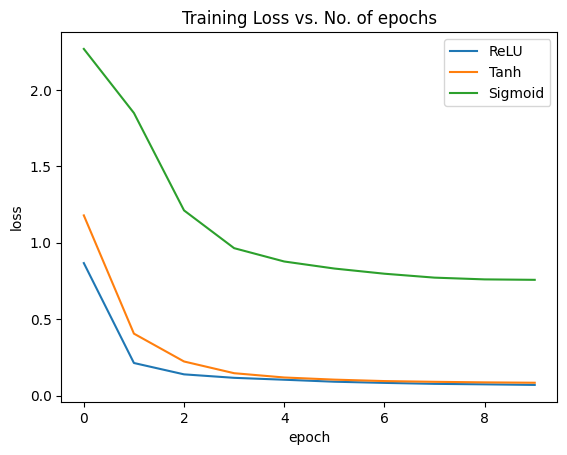

In [ ]:
compare_train_losses()

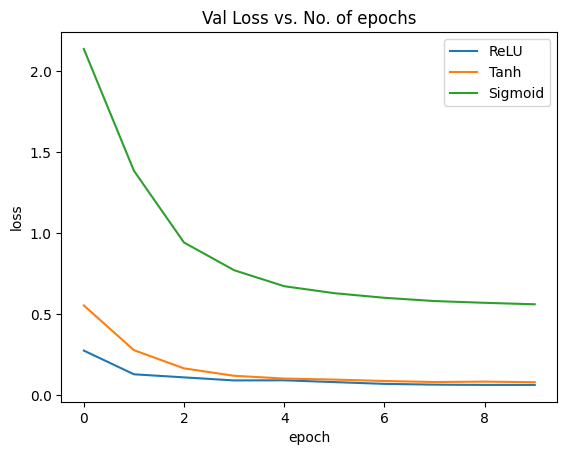

In [ ]:
compare_val_losses()

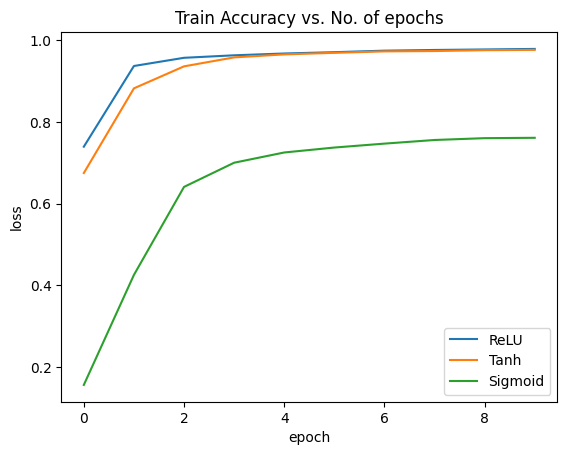

In [ ]:
compare_train_accs()

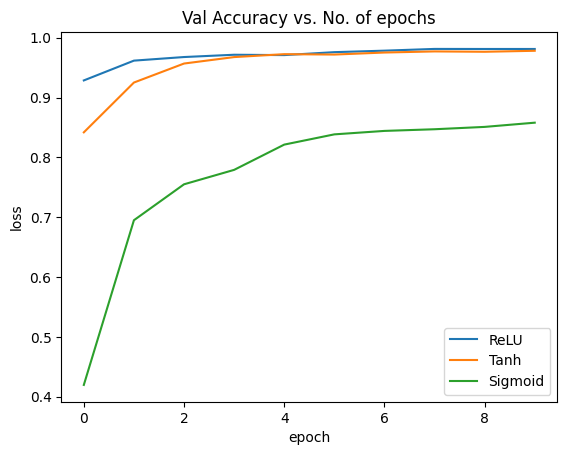

In [ ]:
compare_val_accs()

Conlusion-

* sigmoid- not suitable for multi-class classification, actually it is only suitable for binary classification
* tanh and relu give good results with relu being better due to its simple non-linearity inducing behaviour which leads to lower computations of gradients and non-saturation.